<a href="https://colab.research.google.com/github/KissTK322/Ai-Builder-2023/blob/main/Ai_Builder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Init

In [ ]:
import os
import torch
import torch.utils.data
import torchvision
from PIL import Image
from pycocotools.coco import COCO

class myOwnDataset(torch.utils.data.Dataset):
    def __init__(self, root, annotation, transforms=None):
        self.root = root
        self.transforms = transforms
        self.coco = COCO(annotation)
        self.ids = list(sorted(self.coco.imgs.keys()))

    def __getitem__(self, index):
        coco = self.coco
        img_id = self.ids[index]
        ann_ids = coco.getAnnIds(imgIds=img_id)
        coco_annotation = coco.loadAnns(ann_ids)
        path = coco.loadImgs(img_id)[0]['file_name']
        img = Image.open(os.path.join(self.root, path))

        num_objs = len(coco_annotation)

        boxes = []
        labels = []
        category_ids = [] 
        for i in range(num_objs):
            xmin = coco_annotation[i]['bbox'][0]
            ymin = coco_annotation[i]['bbox'][1]
            xmax = xmin + coco_annotation[i]['bbox'][2]
            ymax = ymin + coco_annotation[i]['bbox'][3]
            boxes.append([xmin, ymin, xmax, ymax])
            labels.append(1) 
            category_ids.append(coco_annotation[i]['category_id'])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)
        img_id = torch.tensor([img_id])
        areas = []
        for i in range(num_objs):
            areas.append(coco_annotation[i]['area'])
        areas = torch.as_tensor(areas, dtype=torch.float32)

        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        my_annotation = {}
        my_annotation["boxes"] = boxes
        my_annotation["labels"] = labels
        my_annotation["image_id"] = img_id
        my_annotation["area"] = areas
        my_annotation["iscrowd"] = iscrowd
        my_annotation["category_id"] = category_ids

        if self.transforms is not None:
            img = self.transforms(img)

        return img, my_annotation

    def __len__(self):
        return len(self.ids)


def get_transform():
    custom_transforms = []
    custom_transforms.append(torchvision.transforms.ToTensor())
    return torchvision.transforms.Compose(custom_transforms)


train_data_dir = '/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/data'
train_coco = '/content/drive/MyDrive/Chula-ParasiteEgg-11/Chula-ParasiteEgg-11/labels.json'

my_dataset = myOwnDataset(root=train_data_dir,
                             annotation=train_coco,
                             transforms=get_transform())

def collate_fn(batch):
    images = []
    annotations = []
    for image, annotation in batch:
        images.append(image)
        annotations.append(annotation)
    return images, annotations

train_batch_size = 1

data_loader = torch.utils.data.DataLoader(my_dataset,
                                          batch_size=train_batch_size,
                                          shuffle=True,
                                          num_workers=4,
                                          collate_fn=collate_fn)

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')



loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:561: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


#Check Data loader

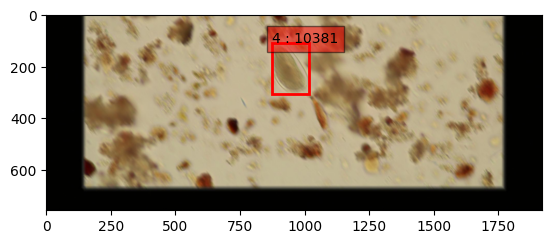

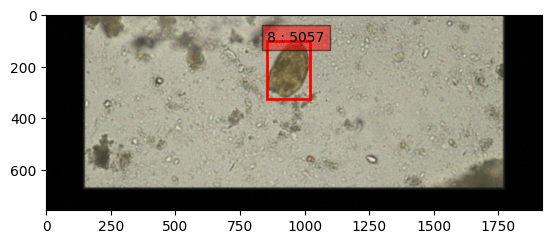

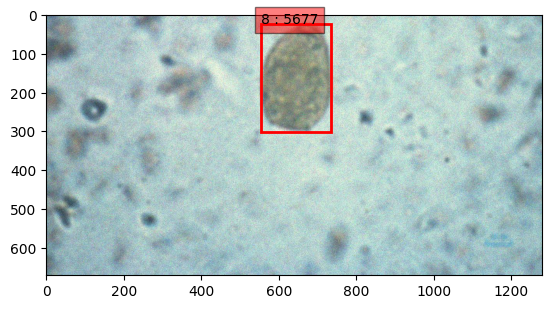

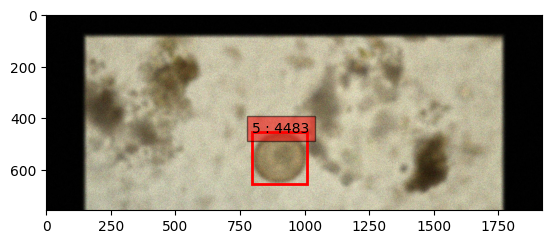

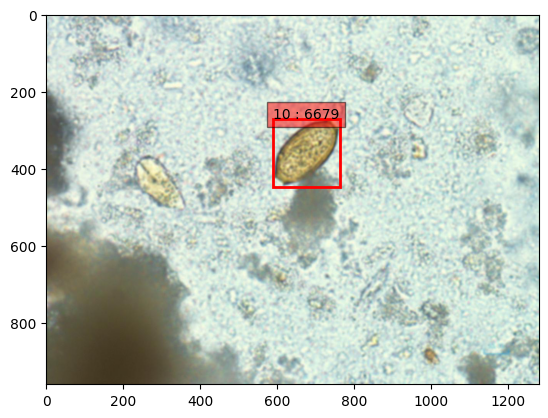

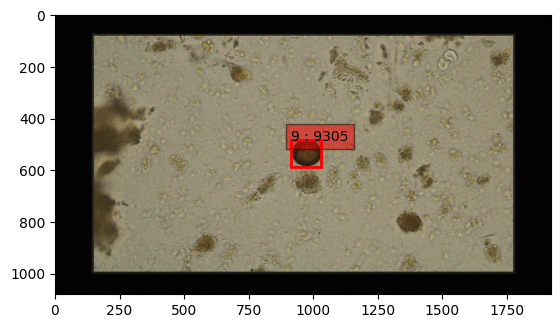

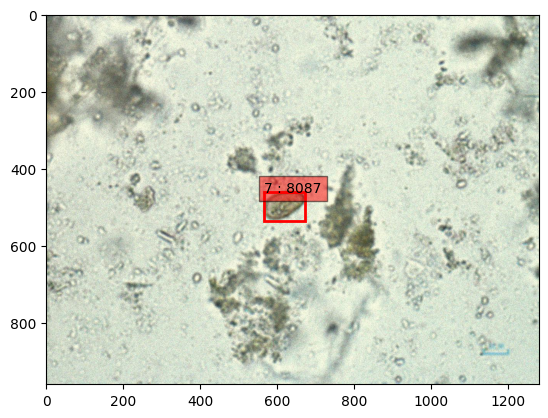

KeyboardInterrupt: ignored

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# loop through all batches in the data loader
for i, (images, annotations) in enumerate(data_loader):
    # loop through all images and annotations in the batch
    for j in range(len(images)):
        # extract the image and annotation data
        image = images[j]
        annotation = annotations[j]

        # get the bounding boxes, labels, and category IDs for the objects in the image
        boxes = annotation['boxes'].cpu().numpy()
        labels = annotation['image_id']
        category_ids = annotation['category_id']


        # plot the image and draw the bounding boxes around the objects
        plt.imshow(np.transpose(image.cpu().numpy(), (1, 2, 0)))
        for box, label, category_id in zip(boxes, labels, category_ids):
            xmin, ymin, xmax, ymax = box
            plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                               fill=False, edgecolor='r', linewidth=2))
            plt.text(xmin, ymin, f'{category_id} : {label}', bbox=dict(facecolor='r', alpha=0.5))
        plt.show()


#Run model

In [ ]:
import torchvision
import torch.optim as optim
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import os

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

checkpoint_path = "/content/drive/MyDrive"

if not os.path.exists(checkpoint_path):
    os.makedirs(checkpoint_path)

checkpoint_file = os.path.join(checkpoint_path, "checkpoint_{epoch}.pt")

num_classes = len(my_dataset.coco.cats)
print(num_classes)
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.SGD(params, lr=0.005, momentum=0.9, weight_decay=0.0005)
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.1)

def my_faster_rcnn_loss(outputs, targets):
    outputs = {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in outputs.items()}
    targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
    loss_dict = model.roi_heads.forward(outputs, targets)
    return sum(loss_dict.values())
import tqdm

model.train()
model.to(device)
num_epochs = 3

for epoch in range(num_epochs):

    progress_bar = tqdm.tqdm(data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
    for images, targets in progress_bar:
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
        lr_scheduler.step()
        progress_bar.set_postfix(loss=losses.item())
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': losses,
    }, checkpoint_file.format(epoch=epoch))
model.eval()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')